# Quickstart Example with Synthetic Recommendation Simulation (Customization)
This notebook provides an example of customizing the REC environment.

This example on the Synthetic Recommendation Simulation consists of the following 3 steps:
1. Setup Synthetic Recommendation Simulation Environment and Interacting Online RL Agent
2. Standardized Environment
3. Customize Environmental Configuration

\* This library uses [d3rlpy](https://github.com/takuseno/d3rlpy)'s algorithm implementations.  

In [60]:
# delete later
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [61]:
# delete later
import warnings
warnings.simplefilter('ignore')

In [62]:
# delete later
import sys
# sys.path.append('/recgym')
sys.path.append('../')
sys.path.append('../../')

In [63]:
# import OFRL modules
import ofrl
from ofrl.policy import OnlineHead
from ofrl.policy import DiscreteEpsilonGreedyHead

# import RECgym modules
import recgym
from recgym.envs.function import inner_reward_function
from recgym.envs.function import user_preference_dynamics
from recgym.envs.rec import RECEnv
# import recgym

# import d3rlpy algorithms
from d3rlpy.algos import DiscreteRandomPolicy

# import from other libraries
import gym

# from sklearn.linear_model import LogisticRegression
from sklearn.utils import check_random_state

In [64]:
from dataclasses import dataclass
from typing import Tuple, Union, Optional

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [65]:
# version
print(ofrl.__version__)

0.0.0


In [66]:
# set random state
random_state = 12345
random_ = check_random_state(random_state)

## 1. Setup Synthetic Recommendation Simulation Environment and Interacting Online RL Agent
To begin with, we briefly describe the basic usage of the environment.

#### RL setup for REC
In REC, the objective of the RL agent is to maximize reward

We often formulate this REC problem as the following Markov Decision Process (MDP):
- `state`: 
   - make the initial state the user_feature of the chosen user
   - update state with state_transition_function
- `action`: selected from n_items
- `reward`: rewards are determined by reward_function

Let's see how it works!

In [67]:
# setup environment
env = RECEnv(
    reward_function = inner_reward_function,
    state_transition_function = user_preference_dynamics,
)

In [68]:
# define a random agent
agent = DiscreteEpsilonGreedyHead(
      base_policy = DiscreteRandomPolicy(),
      name = 'random',
      n_actions = env.n_items,
      epsilon = 1. ,
      random_state = random_state, 
)

In [69]:
print(agent)
print(env.action_space)
print(env.item_feature_vector[0])
print(env.user_feature_vector[0])
print(env.n_items)
print(env.n_users)
print(env.action_space.n)
# self.action_space = spaces.Discrete(3)
print(env.observation_space)

DiscreteEpsilonGreedyHead(base_policy=d3rlpy.algos.random_policy.DiscreteRandomPolicy(action_scaler=None, action_size=1, batch_size=1, gamma=0.0, generated_maxlen=100000, impl=None, n_frames=1, n_steps=1, real_ratio=1.0, reward_scaler=None, scaler=None), name='random', n_actions=100, epsilon=1.0, random_state=12345)
Discrete(100)
[-0.98677296  0.60810345  0.75273367 -0.14494121 -0.05617686]
[ 0.07096832 -0.20273044 -0.33283661  0.06695821  0.8325934 ]
100
100
100
Box(-1.0, 1.0, (5,), float64)


In [70]:
# interact agent with the environment
# only 6 lines are needed for RL interaction
for episode in range(10):
    obs, info= env.reset()
    done = False
    
    while not done:
        action = agent.sample_action_online(obs)
        obs, reward, done, truncated, info = env.step(action)

In [71]:
# state 
print(obs.shape)
print(obs)

(5,)
[ 0.24485713 -0.04221701  0.98331362 -0.37150987 -0.5627295 ]


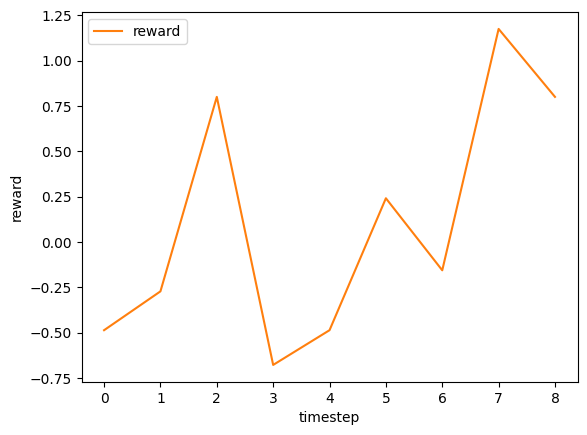

In [72]:
# let's visualize the transition of reward

def visualize_interaction_on_environment(env, agent):
    obs, info = env.reset()
    done = False
    reward_list = []

    while not done:
        action = agent.sample_action_online(obs)

        obs, reward, done, truncated, info = env.step(action)
        reward_list.append(reward)

    # plot
    fig = plt.figure()
    ax1 = fig.add_subplot(111)
    ax1.plot(reward_list[:-1], label='reward', color='tab:orange')
    ax1.set_xlabel('timestep')
    ax1.set_ylabel('reward')
    ax1.legend(loc='upper left')
    plt.show()
    
visualize_interaction_on_environment(env, agent)

In [73]:
a = [1,2,3,4,5,6]
print(a[:-1])

[1, 2, 3, 4, 5]


## 1. Standardized Environment

We provide standardize REC environment i

In [74]:
env = RECEnv(
    reward_function = inner_reward_function,
    state_transition_function = user_preference_dynamics,
)

## 2. Customize Environmental Configuration
Now, we customize the REC simulation environment.

We have the following environmental configurations:
- `reward_function`: Functions that determine how reward is calculated
- `state_transition_function`: Functions that determine state update
- `n_items`: Number of items used for recommendation.
- `n_users`: Number of users used for recommendation.
- `item_feature_dim`: Dimensions of the item feature vectors.
- `user_feature_dim`: Dimensions of the user feature vectors.
- `item_feature_vector`: Feature vectors that characterizes each item.
- `user_feature_vector`: Feature vectors that characterizes each user.
- `noise_std`: Amount of noise an observation has
- `step_per_episode`: Number of timesteps in an episode.

#### Case 1. Customizing the Basic Setup

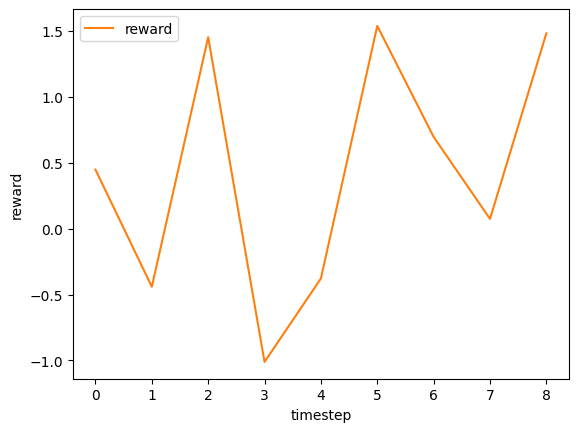

In [75]:
env = RECEnv(
        reward_function = inner_reward_function,
        state_transition_function = user_preference_dynamics,
        n_items = 100,  # we use 100 items
        n_users = 100,  # 100 users exists
        item_feature_dim = 5,  #each item has 5 dimensional features
        user_feature_dim = 5,  #each user has 5 dimensional features
        item_feature_vector = None,  #determine item_feature_vector from n_items and item_feature_dim in RECEnv
        user_feature_vector = None,  #determine user_feature_vector from n_users and user_feature_dim in RECEnv
        noise_std = 0, #not add noise to the observation
        step_per_episode = 10,
)
visualize_interaction_on_environment(env, agent)

#### Case 2. Defining the Items and Users

In [76]:
# we use the following items for recommendation
item_features = np.sign(random_.normal(size=(100, 5))).astype(int)
item_names, feature_names = [f"ad{i+1}" for i in range(100)], [f"feature{i+1}" for i in range(5)]
item_df = pd.DataFrame(item_features, columns=feature_names, index=item_names)
item_df

,feature1,feature2,feature3,feature4,feature5
ad1,-1,1,-1,-1,1
ad2,1,1,1,1,1
ad3,1,-1,1,1,1
ad4,1,-1,-1,1,-1
ad5,-1,1,1,-1,-1
...,...,...,...,...,...
ad96,1,-1,-1,-1,1
ad97,1,1,-1,1,1
ad98,-1,-1,1,1,-1
ad99,-1,1,-1,1,1


In [77]:
# we assume that the following 100 users 
user_features = np.sign(random_.normal(size=(100, 5))).astype(int)
user_names, feature_names = [f"user{i+1}" for i in range(100)], [f"feature{i+1}" for i in range(5)]
user_df = pd.DataFrame(user_features, columns=feature_names, index=user_names)
user_df

,feature1,feature2,feature3,feature4,feature5
user1,-1,-1,-1,1,1
user2,-1,-1,1,1,-1
user3,-1,-1,1,1,-1
user4,1,1,1,1,1
user5,-1,-1,1,1,1
...,...,...,...,...,...
user96,-1,-1,-1,-1,1
user97,1,-1,1,1,-1
user98,1,-1,1,-1,-1
user99,-1,1,-1,1,-1


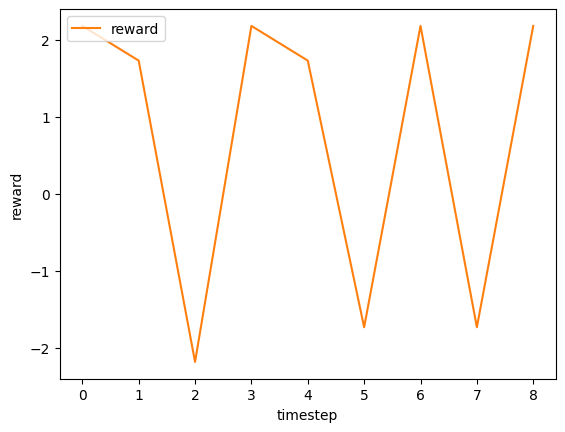

In [78]:
# using the above data, we can simulate an recommendation as follows
env = RECEnv(
        reward_function = inner_reward_function,
        state_transition_function = user_preference_dynamics,
        n_items = 100,  # we use 100 items
        n_users = 100,  # 100 users exists
        item_feature_dim = 5,  #each item has 5 dimensional features
        user_feature_dim = 5,  #each user has 5 dimensional features
        item_feature_vector = item_features, # use item features defined above
        user_feature_vector = user_features, # use user features defined above
        noise_std = 0, #not add noise to the observation
        step_per_episode = 10,
)
visualize_interaction_on_environment(env, agent)

#### Case 3. Using Customized reward_function

In [79]:
def cos_similar_function(state, action, item_feature_vector):
    inner = state @ item_feature_vector[action]
    reward = inner / (np.linalg.norm(state, ord=2) * np.linalg.norm(item_feature_vector[action], ord=2))
    return reward


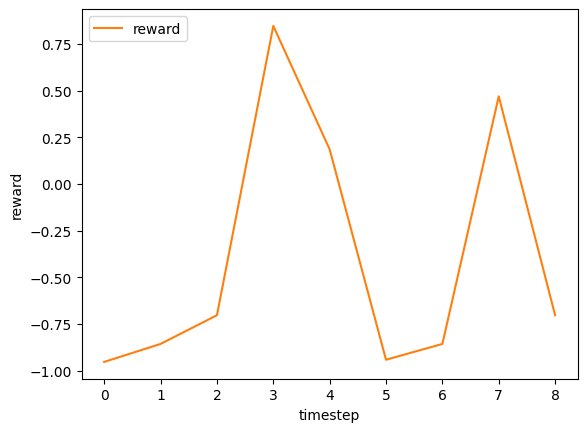

In [80]:
# setup environment
env = RECEnv(
    reward_function = cos_similar_function,
    state_transition_function = user_preference_dynamics,
)
visualize_interaction_on_environment(env, agent)


#### Case 4. Using Customized state_transition_function

In [81]:
def user_preference_dynamics_lose_interest(state, action, item_feature_vector, alpha = 1):
    np.where(item_feature_vector[action] > 0, alpha * state)
    np.where(item_feature_vector[action] < 0, alpha * state)
    state = state + alpha * state @ item_feature_vector[action] * item_feature_vector[action] 
    state = state / np.linalg.norm(state, ord=2)
    return state

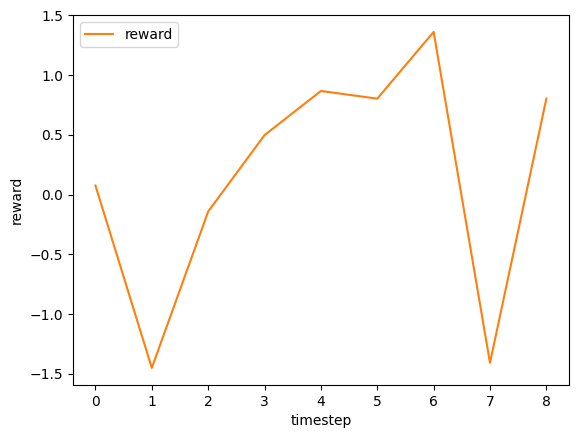

In [82]:
# setup environment
env = RECEnv(
    reward_function = inner_reward_function,
    state_transition_function = user_preference_dynamics,
)
visualize_interaction_on_environment(env, agent)


For data collection and visualization, please refer to [examples/quickstart/REC_synthetic_data_collection.ipynb](https://github.com/negocia-inc/REC_reinforcement_learing/blob/ope/examples/quickstart/REC_synthetic_data_collection.ipynb). 

For offline RL and OPE, please refer to [examples/quickstart/REC_synthetic_discrete_basic.ipynb](https://github.com/negocia-inc/REC_reinforcement_learing/blob/ope/examples/quickstart/REC_synthetic_discrete_basic.ipynb) and [examples/quickstart/REC_synthetic_continuous_basic.ipynb](https://github.com/negocia-inc/REC_reinforcement_learing/blob/ope/examples/quickstart/REC_synthetic_continuous_basic.ipynb).

For advanced topics regarding OPE and OPS, please refer to [examples/quickstart/REC_synthetic_discrete_advanced.ipynb](https://github.com/negocia-inc/REC_reinforcement_learing/blob/ope/examples/quickstart/REC_synthetic_basic_advanced.ipynb) and [examples/quickstart/REC_synthetic_continuous_advanced.ipynb](https://github.com/negocia-inc/REC_reinforcement_learing/blob/ope/examples/quickstart/REC_synthetic_continuous_advanced.ipynb).

## Reference

- Takuma Seno and Michita Imai. \
"d3rlpy: An Offline Deep Reinforcement Library.", 2021.

- Di Wu, Xiujun Chen, Xun Yang, Hao Wang, Qing Tan, Xiaoxun Zhang, Jian Xu, and Kun Gai. \
"Budget Constrained Bidding by Model-free Reinforcement Learning in Display Advertising.", 2018.

- Jun Zhao, Guang Qiu, Ziyu Guan, Wei Zhao, and Xiaofei He. \
"Deep Reinforcement Learning for Sponsored Search Real-time Bidding.", 2018.

- Greg Brockman, Vicki Cheung, Ludwig Pettersson, Jonas Schneider, John Schulman, Jie Tang, and Wojciech Zaremba. \
"OpenAI Gym.", 2016.